# Summary statistics

`ScmRun` objects have methods specific to calculating summary statistics. In this notebook we demonstrate them.

In [1]:
# NBVAL_IGNORE_OUTPUT
import traceback

import matplotlib.pyplot as plt
import numpy as np

from scmdata.run import ScmRun, run_append

In [2]:
plt.rcParams["figure.figsize"] = (12, 8)

## Helper bits and piecs

In [3]:
def new_timeseries(
    n=101,
    count=1,
    model="example",
    scenario="ssp119",
    variable="Surface Temperature",
    unit="K",
    region="World",
    cls=ScmRun,
    **kwargs,
):
    data = np.random.rand(n, count) * np.arange(n)[:, np.newaxis]
    index = 2000 + np.arange(n)
    return cls(
        data,
        columns={
            "model": model,
            "scenario": scenario,
            "variable": variable,
            "region": region,
            "unit": unit,
            **kwargs,
        },
        index=index,
    )

Let's create an `ScmRun` which contains a few variables and a number of runs. Such a dataframe would be used to store the results from an ensemble of simple climate model runs.

In [4]:
# NBVAL_IGNORE_OUTPUT
runs = run_append(
    [
        new_timeseries(
            count=3,
            variable=[
                "Surface Temperature",
                "Atmospheric Concentrations|CO2",
                "Radiative Forcing",
            ],
            unit=["K", "ppm", "W/m^2"],
            run_id=run_id,
        )
        for run_id in range(10)
    ]
)
runs.metadata["source"] = "fake data"
runs

<scmdata.ScmRun (timeseries: 30, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      model region  run_id scenario   unit                        variable
	0   example  World       0   ssp119      K             Surface Temperature
	1   example  World       0   ssp119    ppm  Atmospheric Concentrations|CO2
	2   example  World       0   ssp119  W/m^2               Radiative Forcing
	3   example  World       1   ssp119      K             Surface Temperature
	4   example  World       1   ssp119    ppm  Atmospheric Concentrations|CO2
	5   example  World       1   ssp119  W/m^2               Radiative Forcing
	6   example  World       2   ssp119      K             Surface Temperature
	7   example  World       2   ssp119    ppm  Atmospheric Concentrations|CO2
	8   example  World       2   ssp119  W/m^2               Radiative Forcing
	9   example  World       3   ssp119      K             Surface Temperature
	10  example  World       3   ssp119    ppm  At

## `process_over`

The `process_over` method allows us to calculate a specific set of statistics on groups of timeseries. A number of pandas functions can be called including "sum", "mean" and "describe".

In [5]:
print(runs.process_over.__doc__)


        Process the data over the input columns.

        Parameters
        ----------
        cols
            Columns to perform the operation on. The timeseries will be grouped by all
            other columns in :attr:`meta`.

        operation : str or func
            The operation to perform.

            If a string is provided the equivalent pandas
            function is used. Additional information about the arguments for the pandas
            groupby functions can be found at <https://pandas.pydata.org/pandas-docs/
            stable/reference/groupby.html>`_.

            If a function is provided, will be applied to each group. The function must
            take a dataframe as it's first argument and return a DataFrame, Series or scalar.

            Note that quantile means the value of the data at a given point in the cumulative
            distribution of values at each point in the timeseries, for each timeseries
            once the groupby is applied. As a result

### Mean

In [6]:
# NBVAL_IGNORE_OUTPUT
mean = runs.process_over(cols="run_id", operation="mean")
mean

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   ppm   Atmospheric Concentrations|CO2         0.0    0.526285    0.945569    1.799971    2.545838    3.219059    2.389249  ...   48.979674   39.758000   50.871710   31.594738   51.736475   33.895767   45.427016
                        W/m^2 Radiative Forcing                      0.0    0.515048    0.964497    1.839119    2.341135    2.721128    3.447255  ...   42.538053   49.052837   45.974170   48.310009   46.609716   41.498613   43.566424
                        K     Surface Temperature                    0.0    0.588578    1.079394    1.556941    2.279515    2.337910    2.934050  ...   50.172961   48.646514   52.074567   49.058508   41.899284   68.295022   37.437423

[3 rows x 101 columns]

### Median

In [7]:
# NBVAL_IGNORE_OUTPUT
median = runs.process_over(cols="run_id", operation="median")
median

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   ppm   Atmospheric Concentrations|CO2         0.0    0.551081    0.902741    1.957886    2.515775    3.297474    2.260772  ...   54.212954   38.896006   56.010874   24.637007   58.000432   24.847473   38.263349
                        W/m^2 Radiative Forcing                      0.0    0.491703    1.025188    2.039572    2.140785    2.625981    3.919837  ...   31.398694   46.865498   46.281889   45.303382   51.441088   38.517304   46.195366
                        K     Surface Temperature                    0.0    0.582835    0.957860    1.519935    2.387118    2.249687    2.539915  ...   56.318353   51.782495   54.000212   50.375075   29.904516   80.760165   41.456292

[3 rows x 101 columns]

### Describe

In [18]:
# NBVAL_IGNORE_OUTPUT
describe = runs.process_over(cols="run_id", operation="describe")
describe

time                                                         2000-01-01                                ... 2100-01-01                                                                  
                                                                  count mean  std  min  25%  50%  75%  ...       mean        std        min        25%        50%        75%        max
model   region scenario unit  variable                                                                 ...                                                                             
example World  ssp119   ppm   Atmospheric Concentrations|CO2       10.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  45.427016  26.489961   6.517092  26.561753  38.263349  71.868567  80.670135
                        W/m^2 Radiative Forcing                    10.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  43.566424  20.441180  19.976334  22.418913  46.195366  56.840171  74.447650
                        K     Surface Temperature                  10.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  37.437423  18.642714   1.686431  30.382879  41.456292  48.495553  60.186064

[3 rows x 808 columns]

### Arbitrary functions

You are not constrained to only 

### Other quantiles

In [9]:
# NBVAL_IGNORE_OUTPUT
lower_likely_quantile = runs.process_over(
    cols="run_id", operation="quantile", q=0.17
)
lower_likely_quantile

time                                                          2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                                                                                                            ...                                                                                    
example World  ssp119   ppm   Atmospheric Concentrations|CO2         0.0    0.344528    0.709651    1.266019    1.362193    2.049970    1.505572  ...   22.041687    8.886611   13.779027    7.896394   19.392326   10.343389   23.525885
                        W/m^2 Radiative Forcing                      0.0    0.354633    0.353834    1.370962    1.560304    2.110196    2.045040  ...   21.551067   16.075779   21.326459   30.654354    9.558785   15.304778   20.760257
                        K     Surface Temperature                    0.0    0.264931    0.536337    0.763692    1.671232    1.254996    1.766867  ...   13.570335   23.098690   22.030732   18.676522   16.663201   44.855867   21.307960

[3 rows x 101 columns]

## `quantiles_over`

If you want to calculate more than one summary statistic, `quantiles_over` will calculate and label multiple summary statistics before returning them.

In [10]:
print(runs.quantiles_over.__doc__)


        Calculate quantiles of the data over the input columns.

        Parameters
        ----------
        cols
            Columns to perform the operation on. The timeseries will be grouped by all
            other columns in :attr:`meta`.

        quantiles
            The quantiles to calculate. This should be a list of quantiles to calculate
            (quantile values between 0 and 1). ``quantiles`` can also include the strings
            "median" or "mean" if these values are to be calculated.

        **kwargs
            Passed to :meth:`~ScmRun.process_over`.

        Returns
        -------
        :class:`pandas.DataFrame`
            The quantiles of the timeseries, grouped by all columns in :attr:`meta`
            other than :obj:`cols`. Each calculated quantile is given a label which is
            stored in the ``quantile`` column within the output index.

        Raises
        ------
        TypeError
            ``operation`` is included in ``kwargs``. The op

In [11]:
# NBVAL_IGNORE_OUTPUT
summary_stats = runs.quantiles_over(
    cols="run_id", quantiles=[0.05, 0.17, 0.5, 0.83, 0.95, "mean", "median"]
)
summary_stats

time                                                                   2000-01-01  2001-01-01  2002-01-01  2003-01-01  2004-01-01  2005-01-01  2006-01-01  ...  2094-01-01  2095-01-01  2096-01-01  2097-01-01  2098-01-01  2099-01-01  2100-01-01
model   region scenario unit  variable                       quantile                                                                                      ...                                                                                    
example World  ssp119   ppm   Atmospheric Concentrations|CO2 0.05             0.0    0.147378    0.550199    0.494555    0.756770    1.523769    0.728476  ...    9.953126    2.661371    7.754637    6.109998    2.823775    4.367451   13.164589
                        W/m^2 Radiative Forcing              0.05             0.0    0.255336    0.052665    0.510529    1.199901    1.195426    1.140723  ...    8.427811   10.148724   20.379887   13.346253    7.319499    4.001396   20.221296
                        K     Surface Temperature            0.05             0.0    0.110880    0.435143    0.519242    0.656322    0.725464    1.036781  ...    2.891607   10.212266    8.729129   11.981943   14.292482   14.451059    6.728648
                        ppm   Atmospheric Concentrations|CO2 0.17             0.0    0.344528    0.709651    1.266019    1.362193    2.049970    1.505572  ...   22.041687    8.886611   13.779027    7.896394   19.392326   10.343389   23.525885
                        W/m^2 Radiative Forcing              0.17             0.0    0.354633    0.353834    1.370962    1.560304    2.110196    2.045040  ...   21.551067   16.075779   21.326459   30.654354    9.558785   15.304778   20.760257
                        K     Surface Temperature            0.17             0.0    0.264931    0.536337    0.763692    1.671232    1.254996    1.766867  ...   13.570335   23.098690   22.030732   18.676522   16.663201   44.855867   21.307960
                        ppm   Atmospheric Concentrations|CO2 0.5              0.0    0.551081    0.902741    1.957886    2.515775    3.297474    2.260772  ...   54.212954   38.896006   56.010874   24.637007   58.000432   24.847473   38.263349
                        W/m^2 Radiative Forcing              0.5              0.0    0.491703    1.025188    2.039572    2.140785    2.625981    3.919837  ...   31.398694   46.865498   46.281889   45.303382   51.441088   38.517304   46.195366
                        K     Surface Temperature            0.5              0.0    0.582835    0.957860    1.519935    2.387118    2.249687    2.539915  ...   56.318353   51.782495   54.000212   50.375075   29.904516   80.760165   41.456292
                        ppm   Atmospheric Concentrations|CO2 0.83             0.0    0.730278    1.142830    2.465886    3.856567    4.476307    3.160502  ...   69.954433   64.616129   84.183248   52.824828   78.106089   63.286780   76.566144
                        W/m^2 Radiative Forcing              0.83             0.0    0.679117    1.527180    2.377898    3.237490    3.394268    4.868894  ...   83.150904   82.356107   66.669743   68.262608   82.648749   72.646209   62.027114
                        K     Surface Temperature            0.83             0.0    0.951341    1.692039    2.376609    3.167713    3.242853    4.348997  ...   80.501993   70.259396   80.037125   85.044305   71.272515   91.788298   52.595852
                        ppm   Atmospheric Concentrations|CO2 0.95             0.0    0.885325    1.491239    2.793136    3.924920    4.658737    4.536146  ...   83.118966   78.530601   86.187330   73.486942   88.136348   84.117903   79.331218
                        W/m^2 Radiative Forcing              0.95             0.0    0.865992    1.762579    2.451370    3.507918    4.247747    5.175456  ...   90.655156   90.683297   81.463461   74.307828   83.781032   90.480861   71.335077
                        K     Surface Temperature            0.95             0.0    0.969446    1.797381    2.5

### Plotting

#### Calculate quantiles within plotting function

We can use `plumeplot` directly to plot quantiles. This will calculate the quantiles as part of making the plot so if you're doing this lots it might be faster to pre-calculate the quantiles, then make the plot instead (see below)

Note that in this case the default setttings in `plumeplot` don't produce anything that helpful, we show how to modify them in the cell below.

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7f219f137040>])

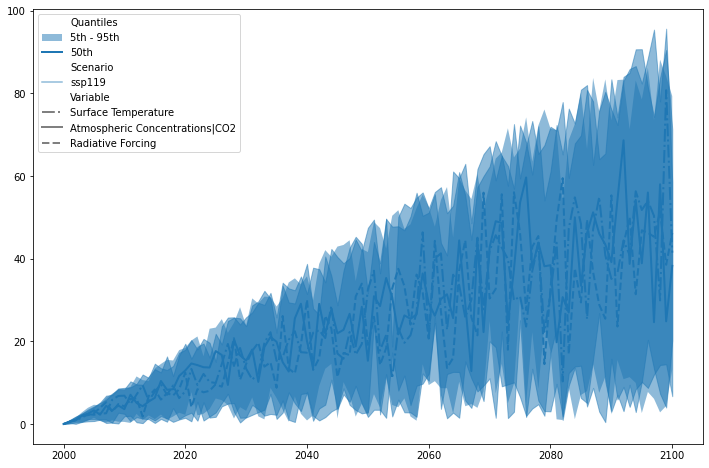

In [12]:
# NBVAL_IGNORE_OUTPUT
runs.plumeplot(quantile_over="run_id")

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7f219f0d20a0>])

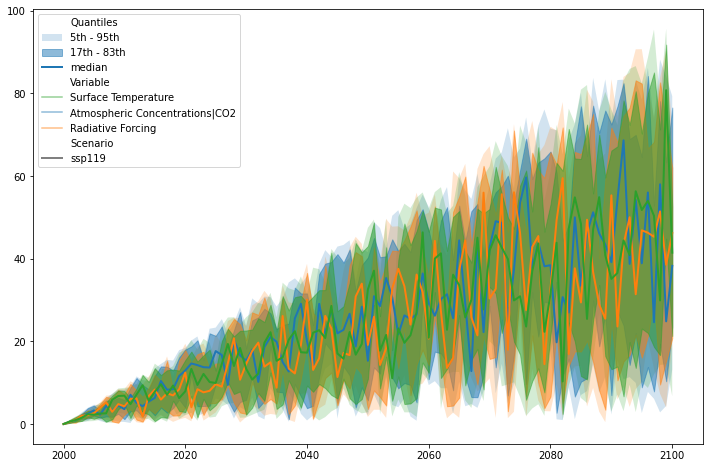

In [13]:
# NBVAL_IGNORE_OUTPUT
runs.plumeplot(
    quantile_over="run_id",
    quantiles_plumes=[
        ((0.05, 0.95), 0.2),
        ((0.17, 0.83), 0.5),
        (("median",), 1.0),
    ],
    hue_var="variable",
    hue_label="Variable",
    style_var="scenario",
    style_label="Scenario",
)

#### Pre-calculated quantiles

Alternately, we can cast the output of `quantiles_over` to an `ScmRun` object for ease of filtering and plotting.

In [14]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun = ScmRun(summary_stats)
summary_stats_scmrun

<scmdata.ScmRun (timeseries: 21, timepoints: 101)>
Time:
	Start: 2000-01-01T00:00:00
	End: 2100-01-01T00:00:00
Meta:
	      model quantile region scenario   unit                        variable
	0   example     0.05  World   ssp119    ppm  Atmospheric Concentrations|CO2
	1   example     0.05  World   ssp119  W/m^2               Radiative Forcing
	2   example     0.05  World   ssp119      K             Surface Temperature
	3   example     0.17  World   ssp119    ppm  Atmospheric Concentrations|CO2
	4   example     0.17  World   ssp119  W/m^2               Radiative Forcing
	5   example     0.17  World   ssp119      K             Surface Temperature
	6   example      0.5  World   ssp119    ppm  Atmospheric Concentrations|CO2
	7   example      0.5  World   ssp119  W/m^2               Radiative Forcing
	8   example      0.5  World   ssp119      K             Surface Temperature
	9   example     0.83  World   ssp119    ppm  Atmospheric Concentrations|CO2
	10  example     0.83  World   ssp11

As discussed above, casting the output of `quantiles_over` to an `ScmRun` object helps avoid repeatedly calculating the quantiles.

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x7f219eff2580>])

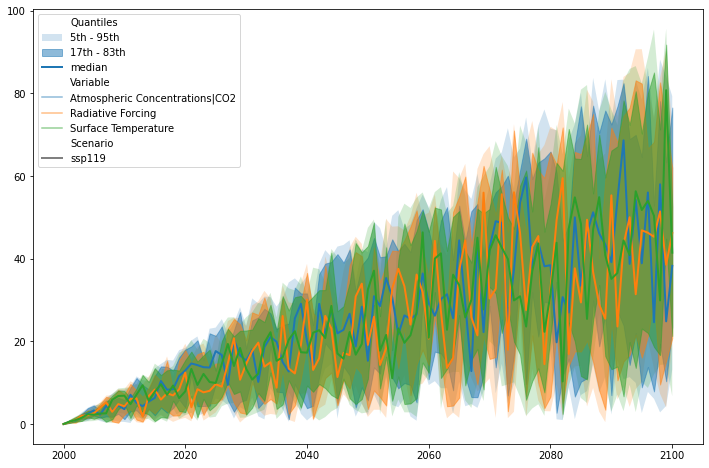

In [15]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun.plumeplot(
    quantiles_plumes=[
        ((0.05, 0.95), 0.2),
        ((0.17, 0.83), 0.5),
        (("median",), 1.0),
    ],
    hue_var="variable",
    hue_label="Variable",
    style_var="scenario",
    style_label="Scenario",
    pre_calculated=True,
)

If we don't want a plume plot, we can always our standard lineplot method.

<AxesSubplot:xlabel='time', ylabel='W/m^2'>

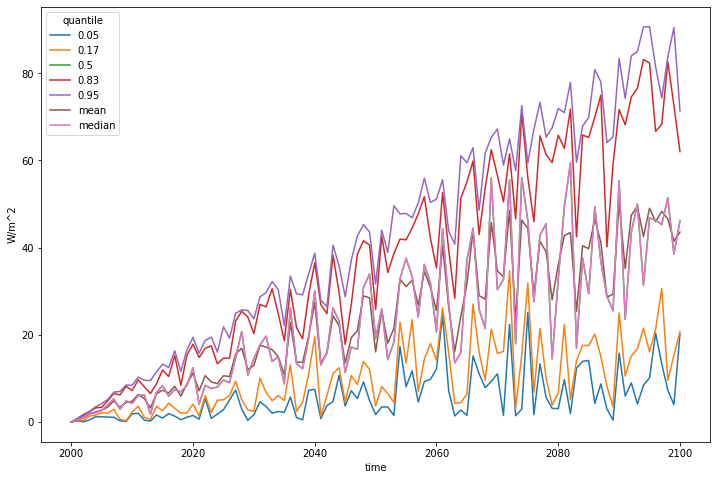

In [16]:
# NBVAL_IGNORE_OUTPUT
summary_stats_scmrun.filter(variable="Radiative Forcing").lineplot(
    hue="quantile"
)